## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
countries = pd.read_csv('Country-data.csv')

In [4]:
# Check the shape
countries.shape

(167, 10)

In [5]:
# Check datatypes & counts
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
# Get descriptive statistics
countries.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
# Identify any missing data
countries.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Preprocessing and Feature Selection

In [8]:
# Drop any non-numeric features (columns)
countries.drop('country', axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation matrix for dataset.')

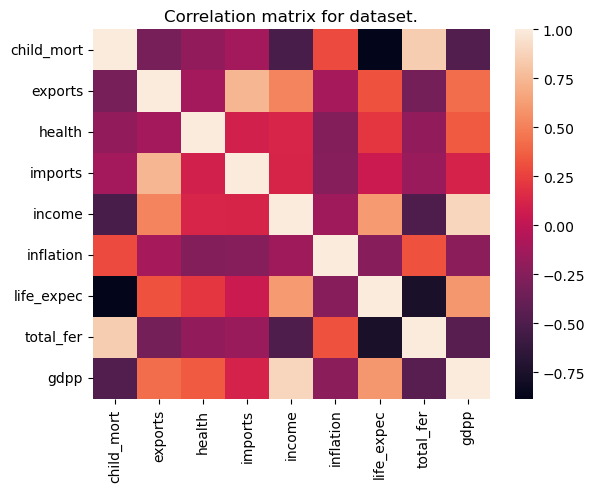

In [9]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
corr = countries.corr()
sns.heatmap(corr)
plt.title('Correlation matrix for dataset.')


Some obvious deductions from this matrix. Child mortality negatively correlated with life expectancy. High income positively correlated with high GDP per capita. Imports and exports positively correlated. 

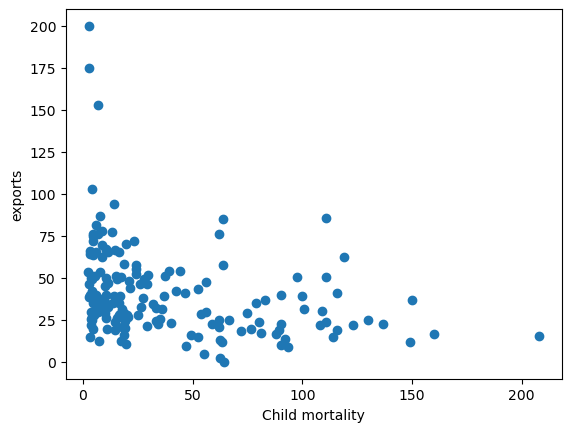

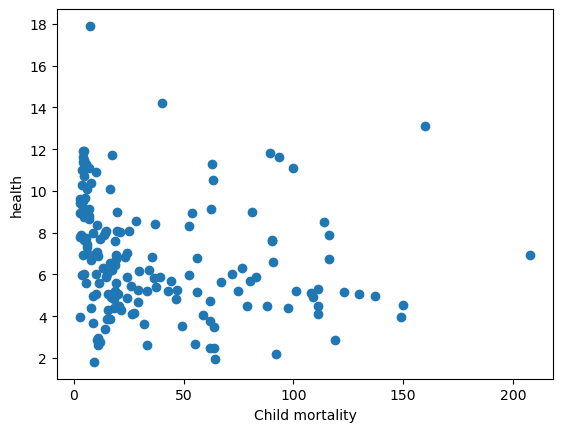

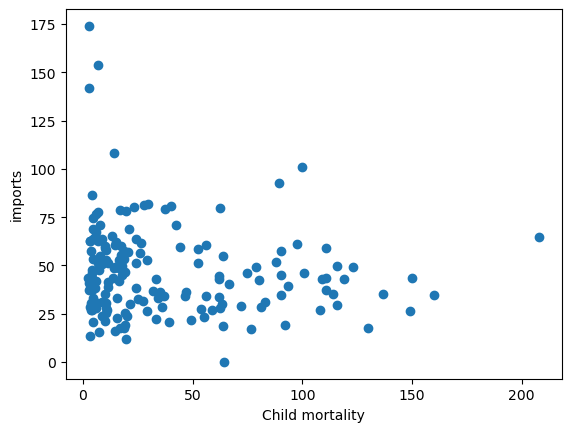

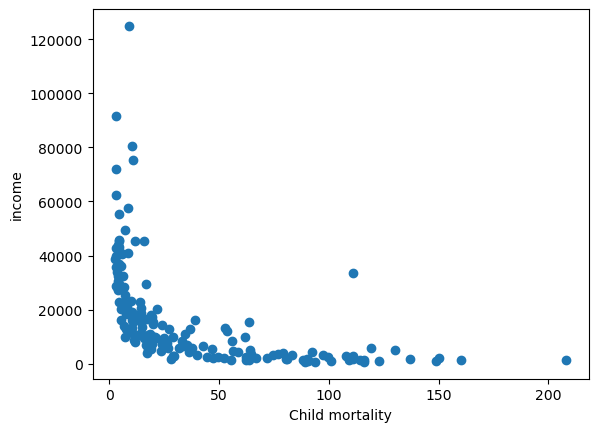

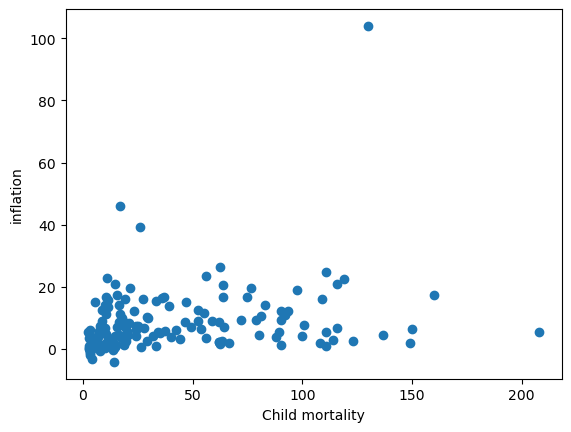

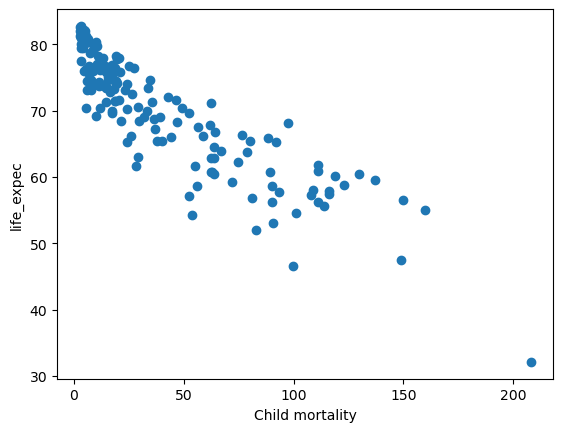

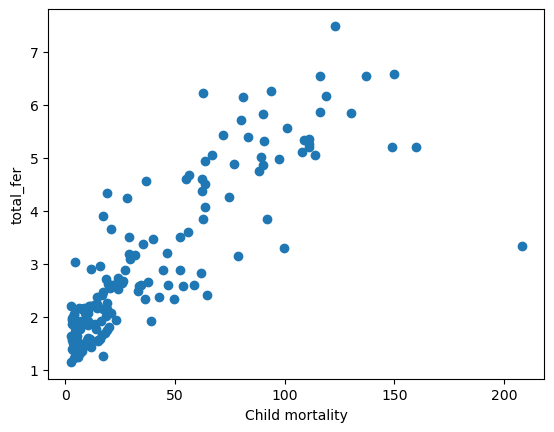

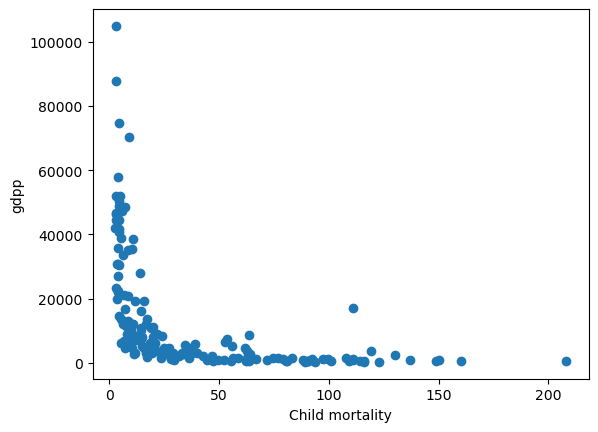

In [10]:
# Explore the continuous independent features against child_mort using scatter plots.
for feature in countries.columns[1:]:
    plt.scatter(countries['child_mort'], countries[feature])
    plt.xlabel('Child mortality')
    plt.ylabel(feature)
    plt.show()
    plt.close()


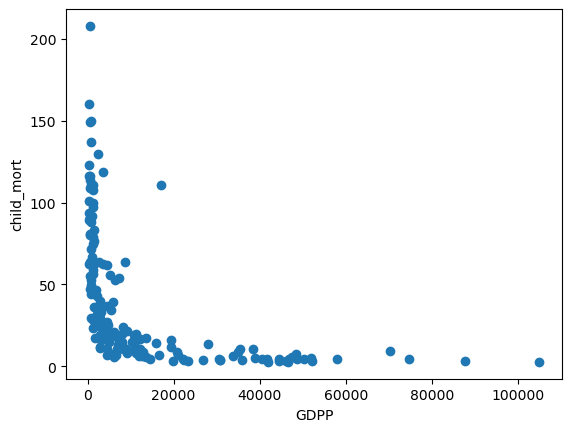

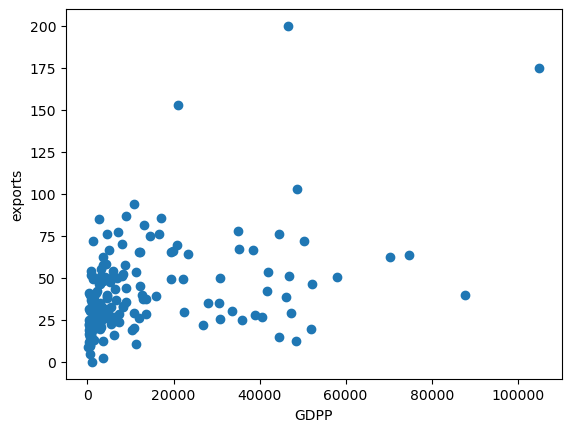

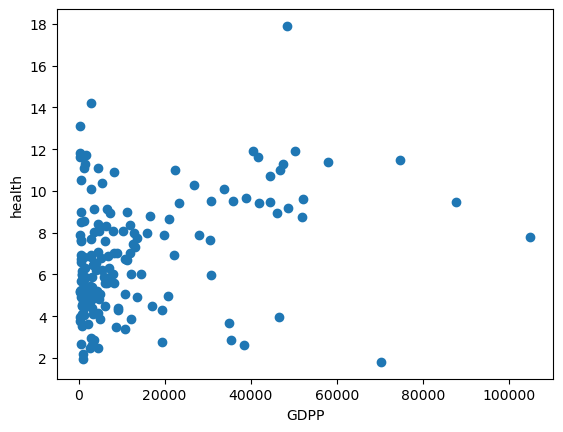

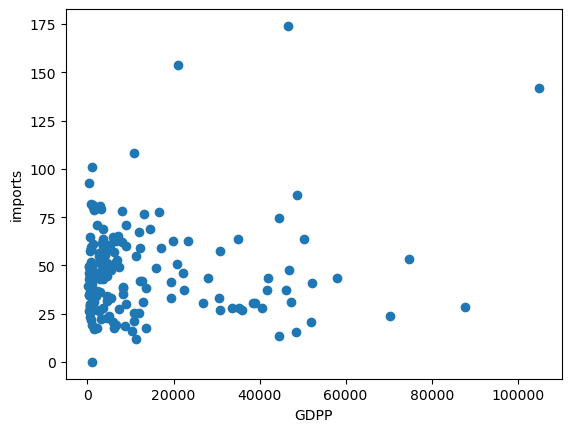

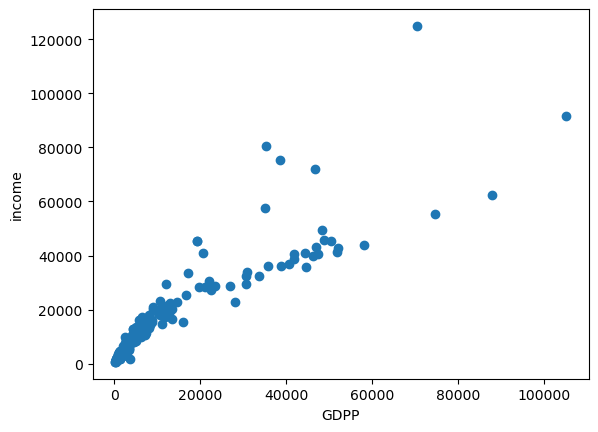

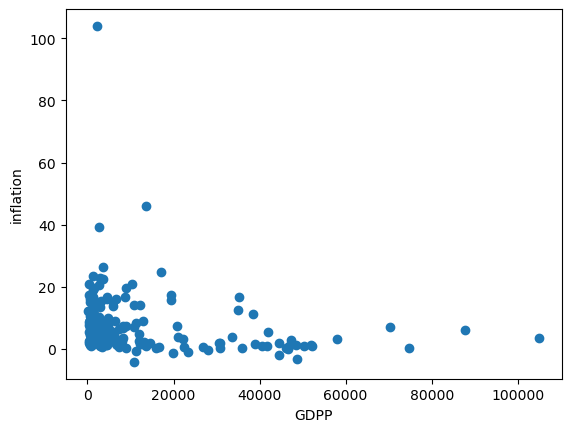

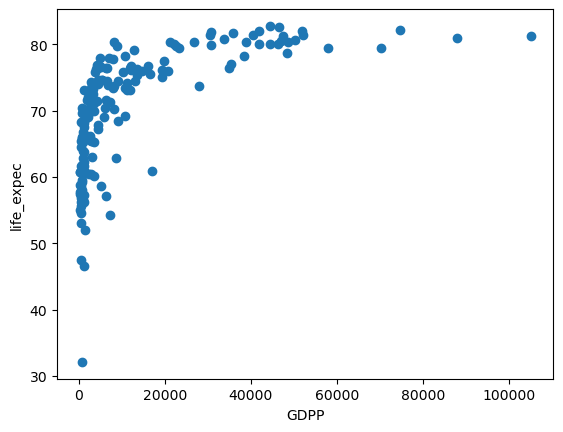

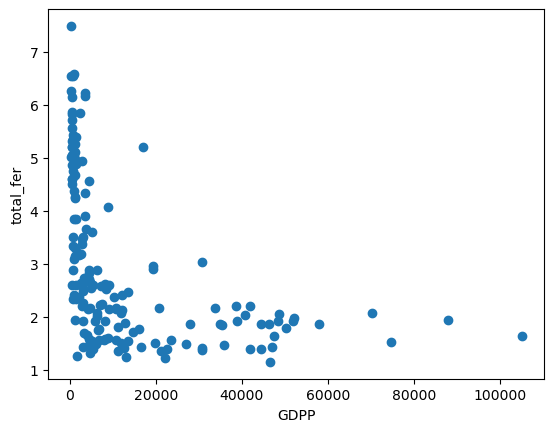

In [11]:
# Explore the continuous independent features against gdpp using scatter plots.
for feature in countries.columns[:8]:
    plt.scatter(countries['gdpp'], countries[feature])
    plt.xlabel('GDPP')
    plt.ylabel(feature)
    plt.show()
    plt.close()

/Users/vanshikagulati/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


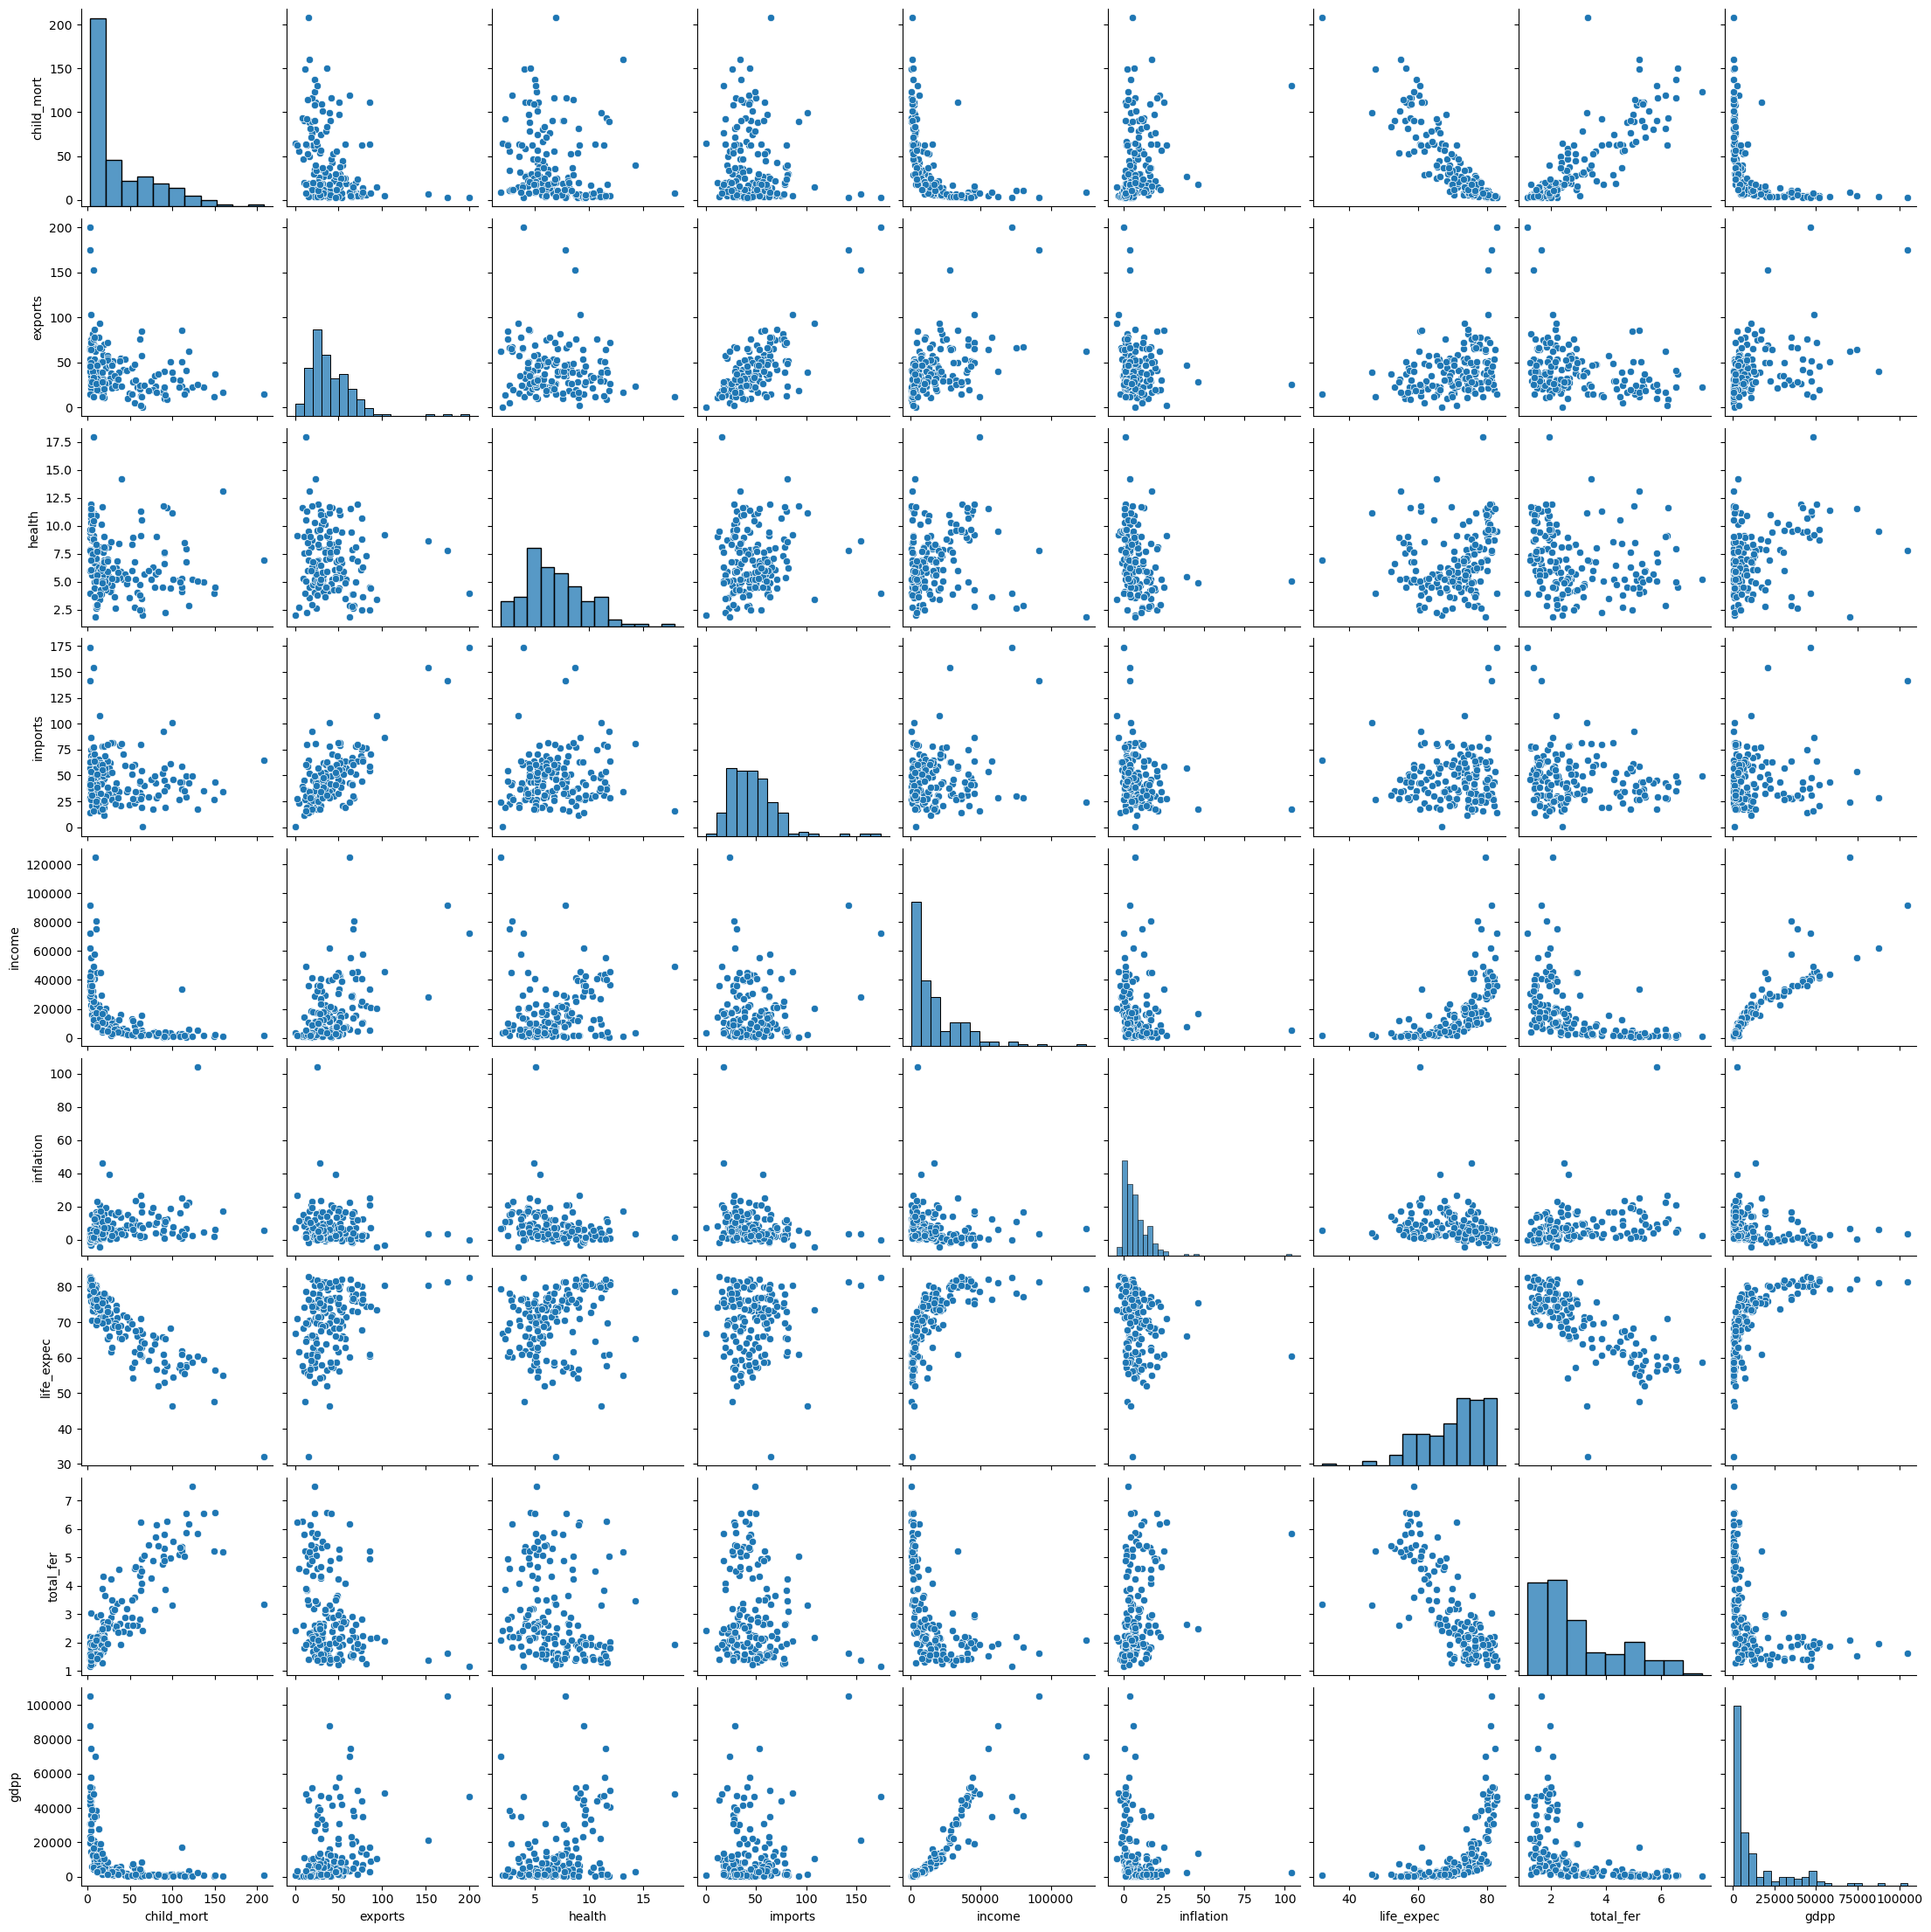

In [12]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(countries)

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [13]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
sc = MinMaxScaler()
scaled = sc.fit_transform(countries)
df_scaled = pd.DataFrame(scaled, columns = countries.columns)

df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

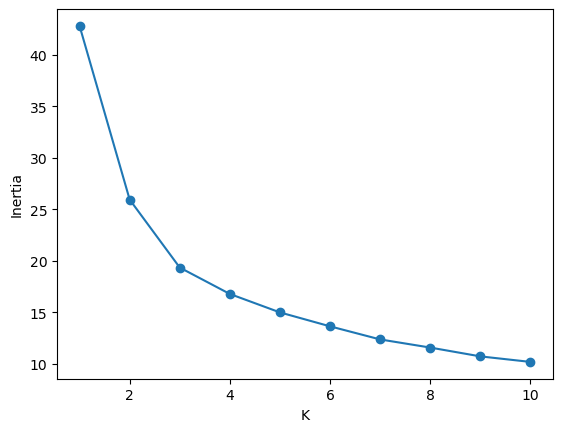

In [14]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

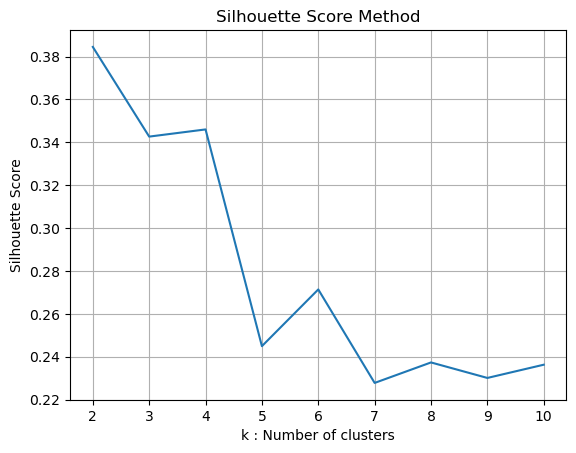

In [15]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

The best silhouette score is at 2 clusters, and the elbow is at 3 clusters. Let's try both.

## Fitting a K-Means Model with the selected K value

In [16]:
# Remember to set the random_state to rseed
X = df_scaled.values.reshape(-1, 9)
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=rseed)
y = kmeans.fit_predict(X)
# visualising y to figure out how to count records in clusters.
y



array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1], dtype=int32)

In [17]:
# Count the number of records in each cluster
cluster0 = len(np.where(y == 0)[0])
cluster1 = len(np.where(y == 1)[0])
print(f'Cluster 0 has {cluster0} records and Cluster 1 has {cluster1} records.')


Cluster 0 has 116 records and Cluster 1 has 51 records.


In [18]:
# Check model performance with the silhouette coefficient
print("Silhouette score of the KMeans model with 2 clusters:", silhouette_score(df_scaled, labels=kmeans.labels_))


Silhouette score of the KMeans model with 2 clusters: 0.384471920619431


## Predictions

In [19]:
# Add the predicted cluster label column to the original dataframe
df_scaled['kmeans2'] = y
df_scaled.head

# countries['kmeans2'] = y
# countries.head

<bound method NDFrame.head of      child_mort   exports    health   imports    income  inflation  \
0      0.426485  0.049482  0.358608  0.257765  0.008047   0.126144   
1      0.068160  0.139531  0.294593  0.279037  0.074933   0.080399   
2      0.120253  0.191559  0.146675  0.180149  0.098809   0.187691   
3      0.566699  0.311125  0.064636  0.246266  0.042535   0.245911   
4      0.037488  0.227079  0.262275  0.338255  0.148652   0.052213   
..          ...       ...       ...       ...       ...        ...   
162    0.129503  0.232582  0.213797  0.302609  0.018820   0.063118   
163    0.070594  0.142032  0.192666  0.100809  0.127750   0.463081   
164    0.100779  0.359651  0.312617  0.460715  0.031200   0.150725   
165    0.261441  0.149536  0.209447  0.197397  0.031120   0.257000   
166    0.391918  0.184556  0.253574  0.177275  0.021473   0.168284   

     life_expec  total_fer      gdpp  kmeans2  
0      0.475345   0.736593  0.003073        1  
1      0.871795   0.078864  0.036

## Visualisation of clusters

Text(0, 0.5, 'GDP per capita')

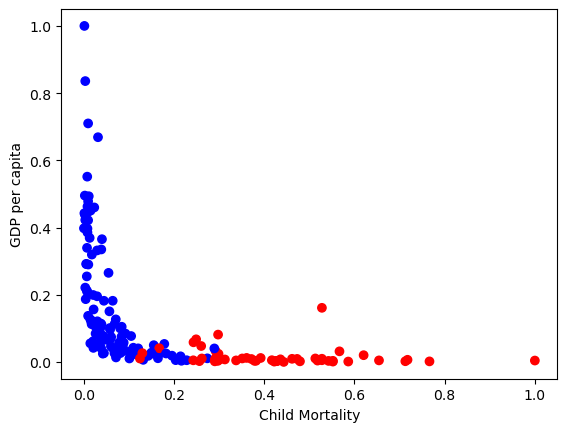

In [40]:
# Visualisation of clusters: child mortality vs gdpp
plt.scatter(df_scaled['child_mort'], df_scaled['gdpp'], c = df_scaled['kmeans2'], cmap='bwr')
plt.xlabel('Child Mortality')
plt.ylabel('GDP per capita')

Text(0, 0.5, 'GDP per capita')

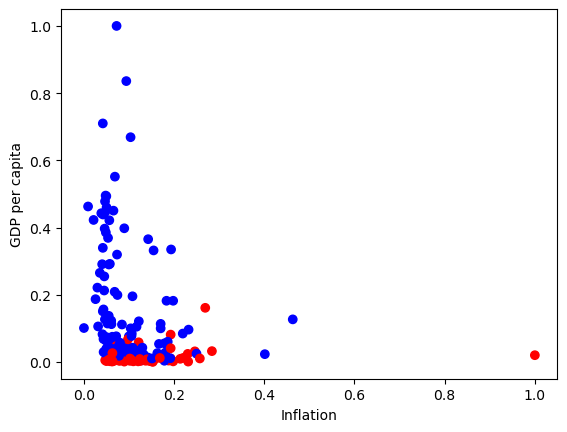

In [41]:
# Visualisation of clusters: inflation vs gdpp
plt.scatter(df_scaled['inflation'], df_scaled['gdpp'], c=df_scaled['kmeans2'], cmap='bwr')
plt.xlabel('Inflation')
plt.ylabel('GDP per capita')

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:** Since the best silhouette score was at k=2, there are only two clusters present in the above graphs. From these, it's clear that high GDP per capita is correlated with low child mortality and low inflation rates. I.e., highly developed countries or developping countries have lower child mortality and inflation. Least developed countries (with normalised GDP per capita between 0 and 0.2) have high child mortality, and perhaps slightly higher inflation.<br><br> The data can be divided into countries with low GDP per capita or least developed countries (red) and developing and developed countries (blue).